In [1]:
import warnings
warnings.simplefilter("ignore")

# DC GAN

## Co-evolution

* 이미지 생성기(generator)와 이미지 분별기(discriminator)가 서로 경쟁하며 트레이닝

<img src="https://datascienceschool.net/upfiles/7b3bb3a945914dc19fe84e3e5b785d0c.png">

<img src="https://datascienceschool.net/upfiles/43de96d9a269488088103949c9bb970d.png">

## Keras 구현

* https://github.com/eriklindernoren/Keras-GAN

In [2]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

Using TensorFlow backend.


## Generator

In [3]:
generator_ = Sequential()
generator_.add(Dense(128 * 7 * 7, activation="relu", input_shape=(100,)))
generator_.add(Reshape((7, 7, 128)))
generator_.add(BatchNormalization(momentum=0.8))
generator_.add(UpSampling2D())
generator_.add(Conv2D(128, kernel_size=3, padding="same"))
generator_.add(Activation("relu"))
generator_.add(BatchNormalization(momentum=0.8)) 
generator_.add(UpSampling2D())
generator_.add(Conv2D(64, kernel_size=3, padding="same"))
generator_.add(Activation("relu"))
generator_.add(BatchNormalization(momentum=0.8))
generator_.add(Conv2D(1, kernel_size=3, padding="same"))
generator_.add(Activation("tanh"))

In [4]:
noise_input = Input(shape=(100,), name="noise_input")
generator = Model(noise_input, generator_(noise_input), name="generator")

In [5]:
generator_.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 128)       512       
__________

In [6]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noise_input (InputLayer)     (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         856705    
Total params: 856,705
Trainable params: 856,065
Non-trainable params: 640
_________________________________________________________________


In [7]:
optimizer = Adam(0.0002, 0.5)

In [8]:
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

In [9]:
noise_data = np.random.normal(0, 1, (32, 100))
generated_images = 0.5 * generator.predict(noise_data) + 0.5
generated_images.shape

(32, 28, 28, 1)

In [10]:
def show_images(generated_images, n=4, m=8, figsize=(9, 5)):
    fig = plt.figure(figsize=figsize)
    plt.subplots_adjust(top=1, bottom=0, hspace=0, wspace=0.05)
    for i in range(n):
        for j in range(m):
            k = i * m + j
            ax = fig.add_subplot(n, m, i * m + j + 1)
            ax.imshow(generated_images[k][:, :, 0], cmap=plt.cm.bone)
            ax.grid(False)
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
    plt.tight_layout()
    plt.show()

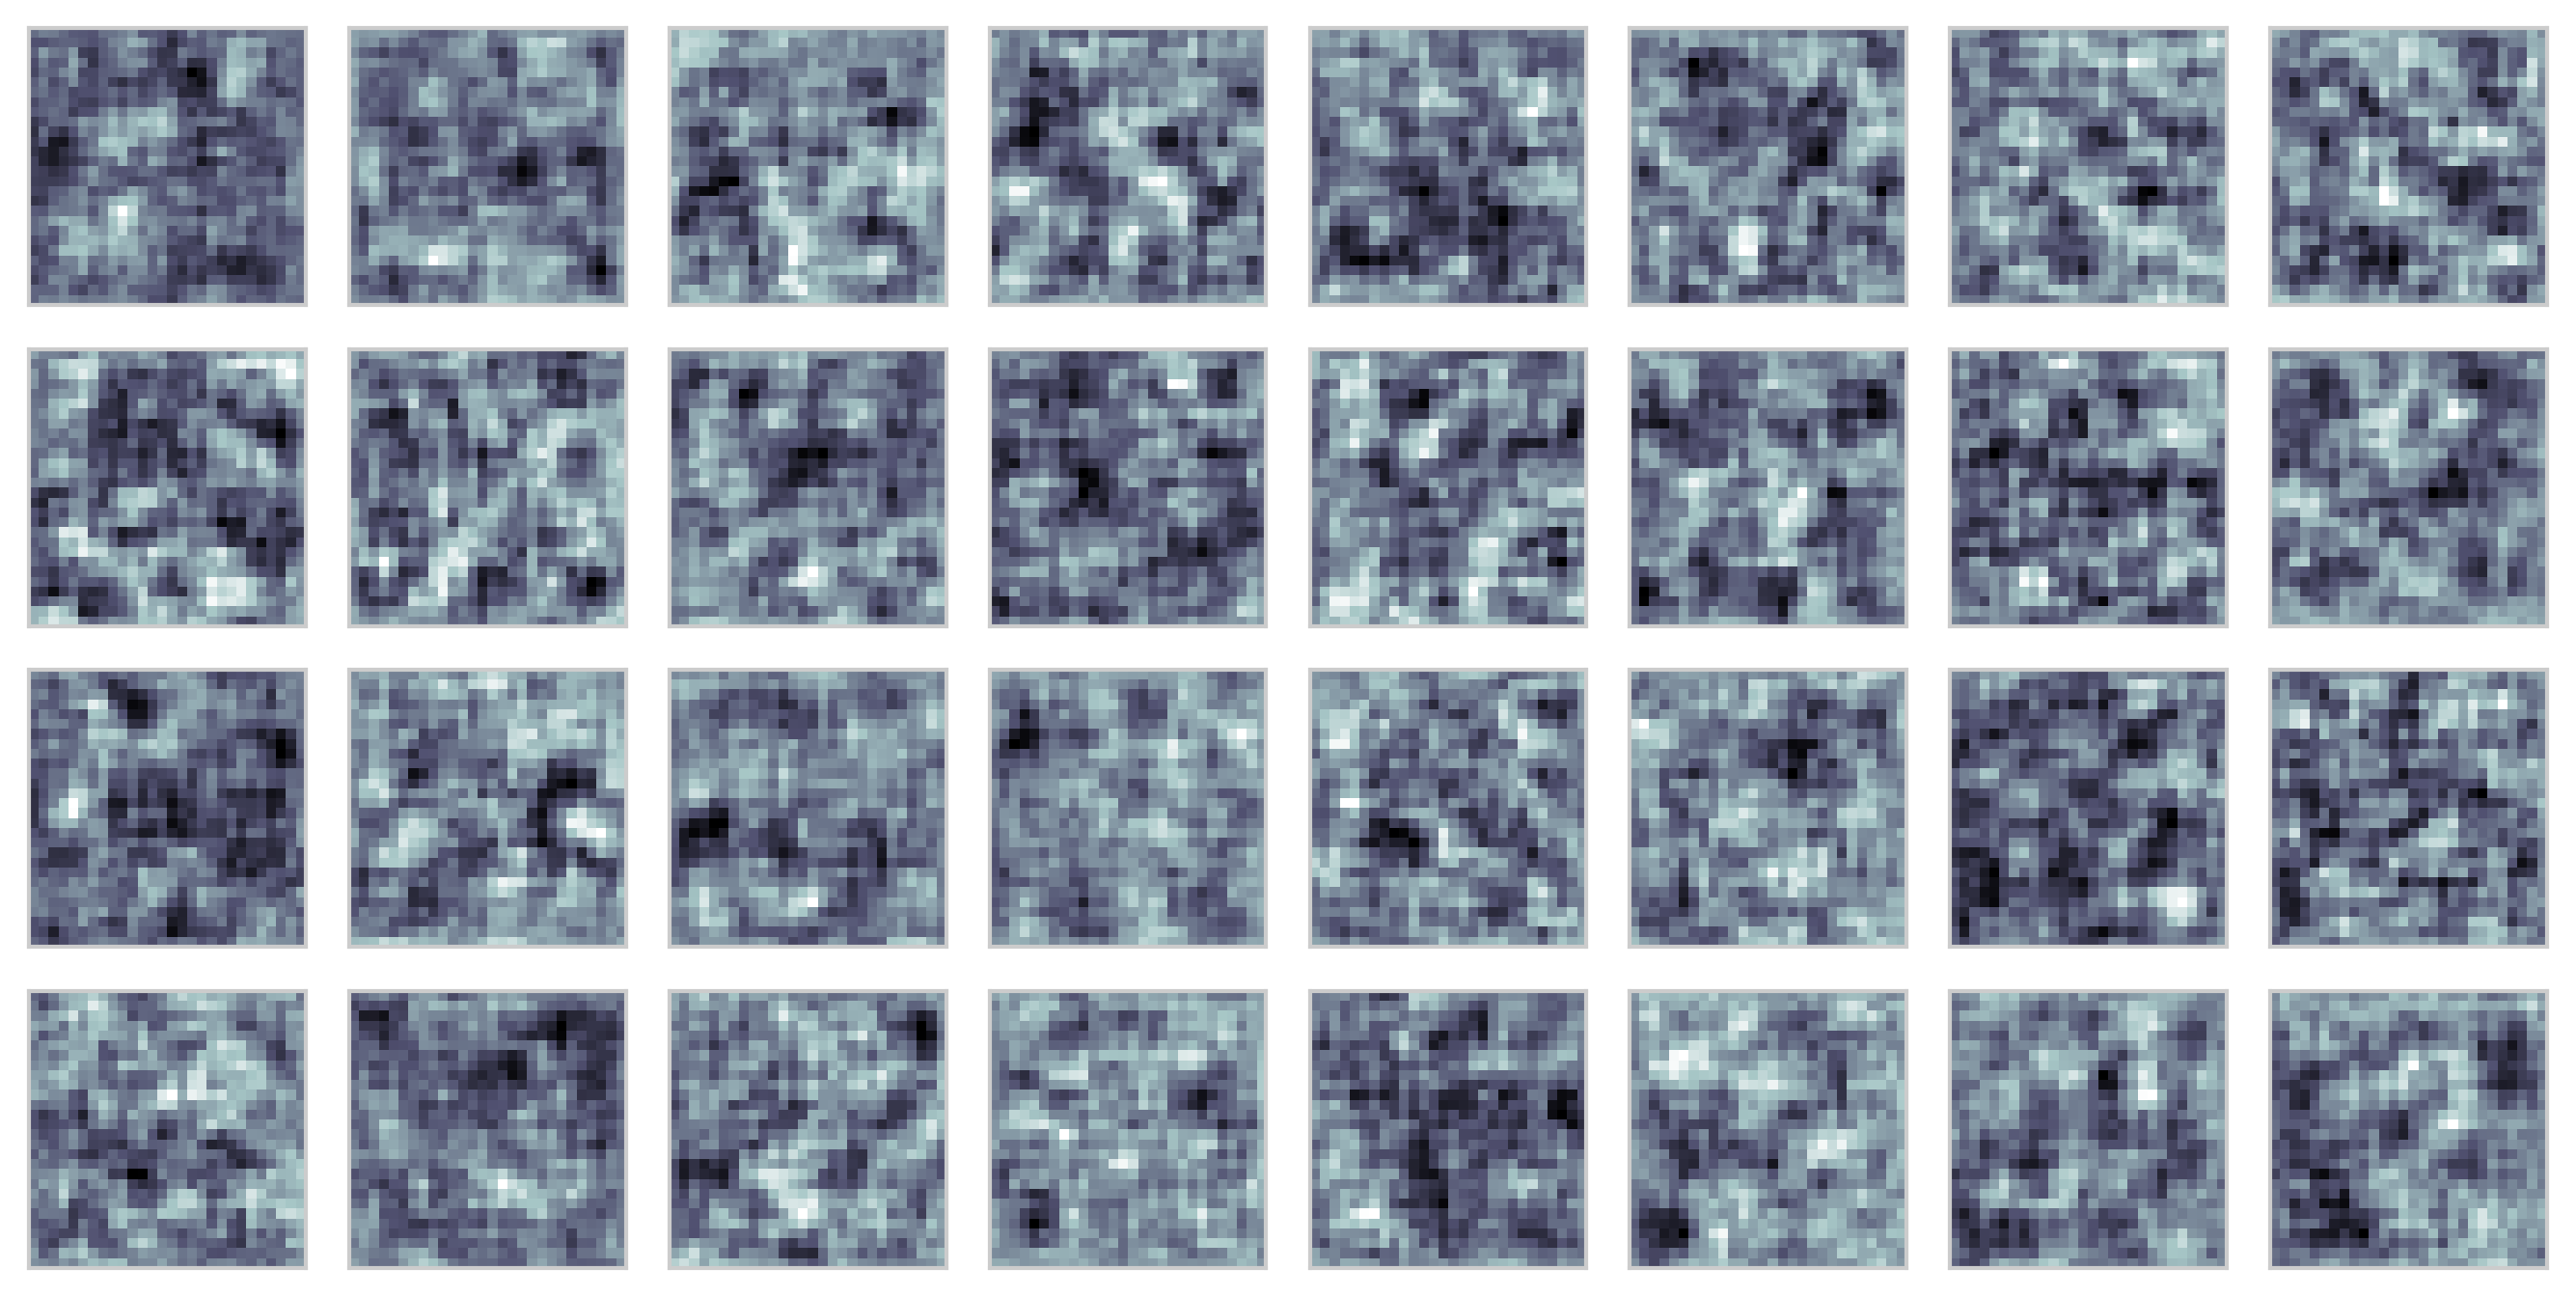

In [11]:
show_images(generated_images)

## Discriminator

In [12]:
discriminator_ = Sequential()

discriminator_.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding="same"))
discriminator_.add(LeakyReLU(alpha=0.2))
discriminator_.add(Dropout(0.25))
discriminator_.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
discriminator_.add(ZeroPadding2D(padding=((0,1),(0,1))))
discriminator_.add(LeakyReLU(alpha=0.2))
discriminator_.add(Dropout(0.25))
discriminator_.add(BatchNormalization(momentum=0.8))
discriminator_.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
discriminator_.add(LeakyReLU(alpha=0.2))
discriminator_.add(Dropout(0.25))
discriminator_.add(BatchNormalization(momentum=0.8))
discriminator_.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
discriminator_.add(LeakyReLU(alpha=0.2))
discriminator_.add(Dropout(0.25))
discriminator_.add(Flatten())
discriminator_.add(Dense(1, activation='sigmoid'))

image_input = Input(shape=(28, 28, 1), name="image_input")

discriminator = Model(image_input, discriminator_(image_input), name="discriminator")

In [13]:
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [14]:
discriminator_.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 64)          0         
__________

In [15]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 28, 28, 1)         0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 392705    
Total params: 392,705
Trainable params: 392,321
Non-trainable params: 384
_________________________________________________________________


## Combined Model 

In [16]:
noise_input2 = Input(shape=(100,), name="noise_input2")
combined = Model(noise_input2, discriminator(generator(noise_input2)))

In [17]:
combined.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noise_input2 (InputLayer)    (None, 100)               0         
_________________________________________________________________
generator (Model)            (None, 28, 28, 1)         856705    
_________________________________________________________________
discriminator (Model)        (None, 1)                 392705    
Total params: 1,249,410
Trainable params: 1,248,386
Non-trainable params: 1,024
_________________________________________________________________


In [18]:
combined.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

## Image

In [19]:
(X_train, _), (_, _) = mnist.load_data()

# Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)

## Training

In [20]:
batch_size = 128
half_batch = int(batch_size / 2)

In [43]:
def train(epochs, print_step=10):
    history = []
    for epoch in range(epochs):

        # discriminator 트레이닝 단계
        #######################################################################3
        
        # 데이터 절반은 실제 이미지, 절반은 generator가 생성한 가짜 이미지
        real_images = X_train[np.random.randint(0, X_train.shape[0], half_batch)]
        y_real = np.ones((half_batch, 1))
        generated_images = generator.predict(np.random.normal(0, 1, (half_batch, 100)))
        y_generated = np.zeros((half_batch, 1))
        
        # discriminator가 실제 이미지와 가짜 이미지를 구별하도록 discriminator를 트레이닝
        discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch(real_images, y_real)
        d_loss_fake = discriminator.train_on_batch(generated_images, y_generated)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # generator 트레이닝 단계
        #######################################################################3
        
        # 전부 generator가 생성한 가짜 이미지를 사용. 
        # discriminator가 구별하지 못하도록 generator를 트레이닝
        noise = np.random.normal(0, 1, (batch_size, 100))
        discriminator.trainable = False
        g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

        # 기록
        record = (epoch, d_loss[0], 100 * d_loss[1], g_loss[0], 100 * g_loss[1])
        history.append(record)
        if epoch % print_step == 0:
            print("%5d [D loss: %.3f, acc.: %.2f%%] [G loss: %.3f, acc.: %.2f%%]" % record)

In [22]:
%%time
history100 = train(100)

  0 [D loss: 0.957, acc.: 32.03%] [G loss: 0.740, acc.: 53.91%]
 10 [D loss: 0.976, acc.: 50.78%] [G loss: 0.360, acc.: 91.41%]
 20 [D loss: 1.114, acc.: 50.00%] [G loss: 0.340, acc.: 94.53%]
 30 [D loss: 1.160, acc.: 50.00%] [G loss: 0.331, acc.: 94.53%]
 40 [D loss: 1.240, acc.: 50.00%] [G loss: 0.268, acc.: 96.88%]
 50 [D loss: 1.223, acc.: 50.00%] [G loss: 0.312, acc.: 95.31%]
 60 [D loss: 1.227, acc.: 50.00%] [G loss: 0.264, acc.: 99.22%]
 70 [D loss: 1.199, acc.: 50.00%] [G loss: 0.316, acc.: 96.88%]
 80 [D loss: 1.180, acc.: 50.00%] [G loss: 0.307, acc.: 97.66%]
 90 [D loss: 1.209, acc.: 50.00%] [G loss: 0.267, acc.: 98.44%]
CPU times: user 13.7 s, sys: 2 s, total: 15.7 s
Wall time: 15.4 s


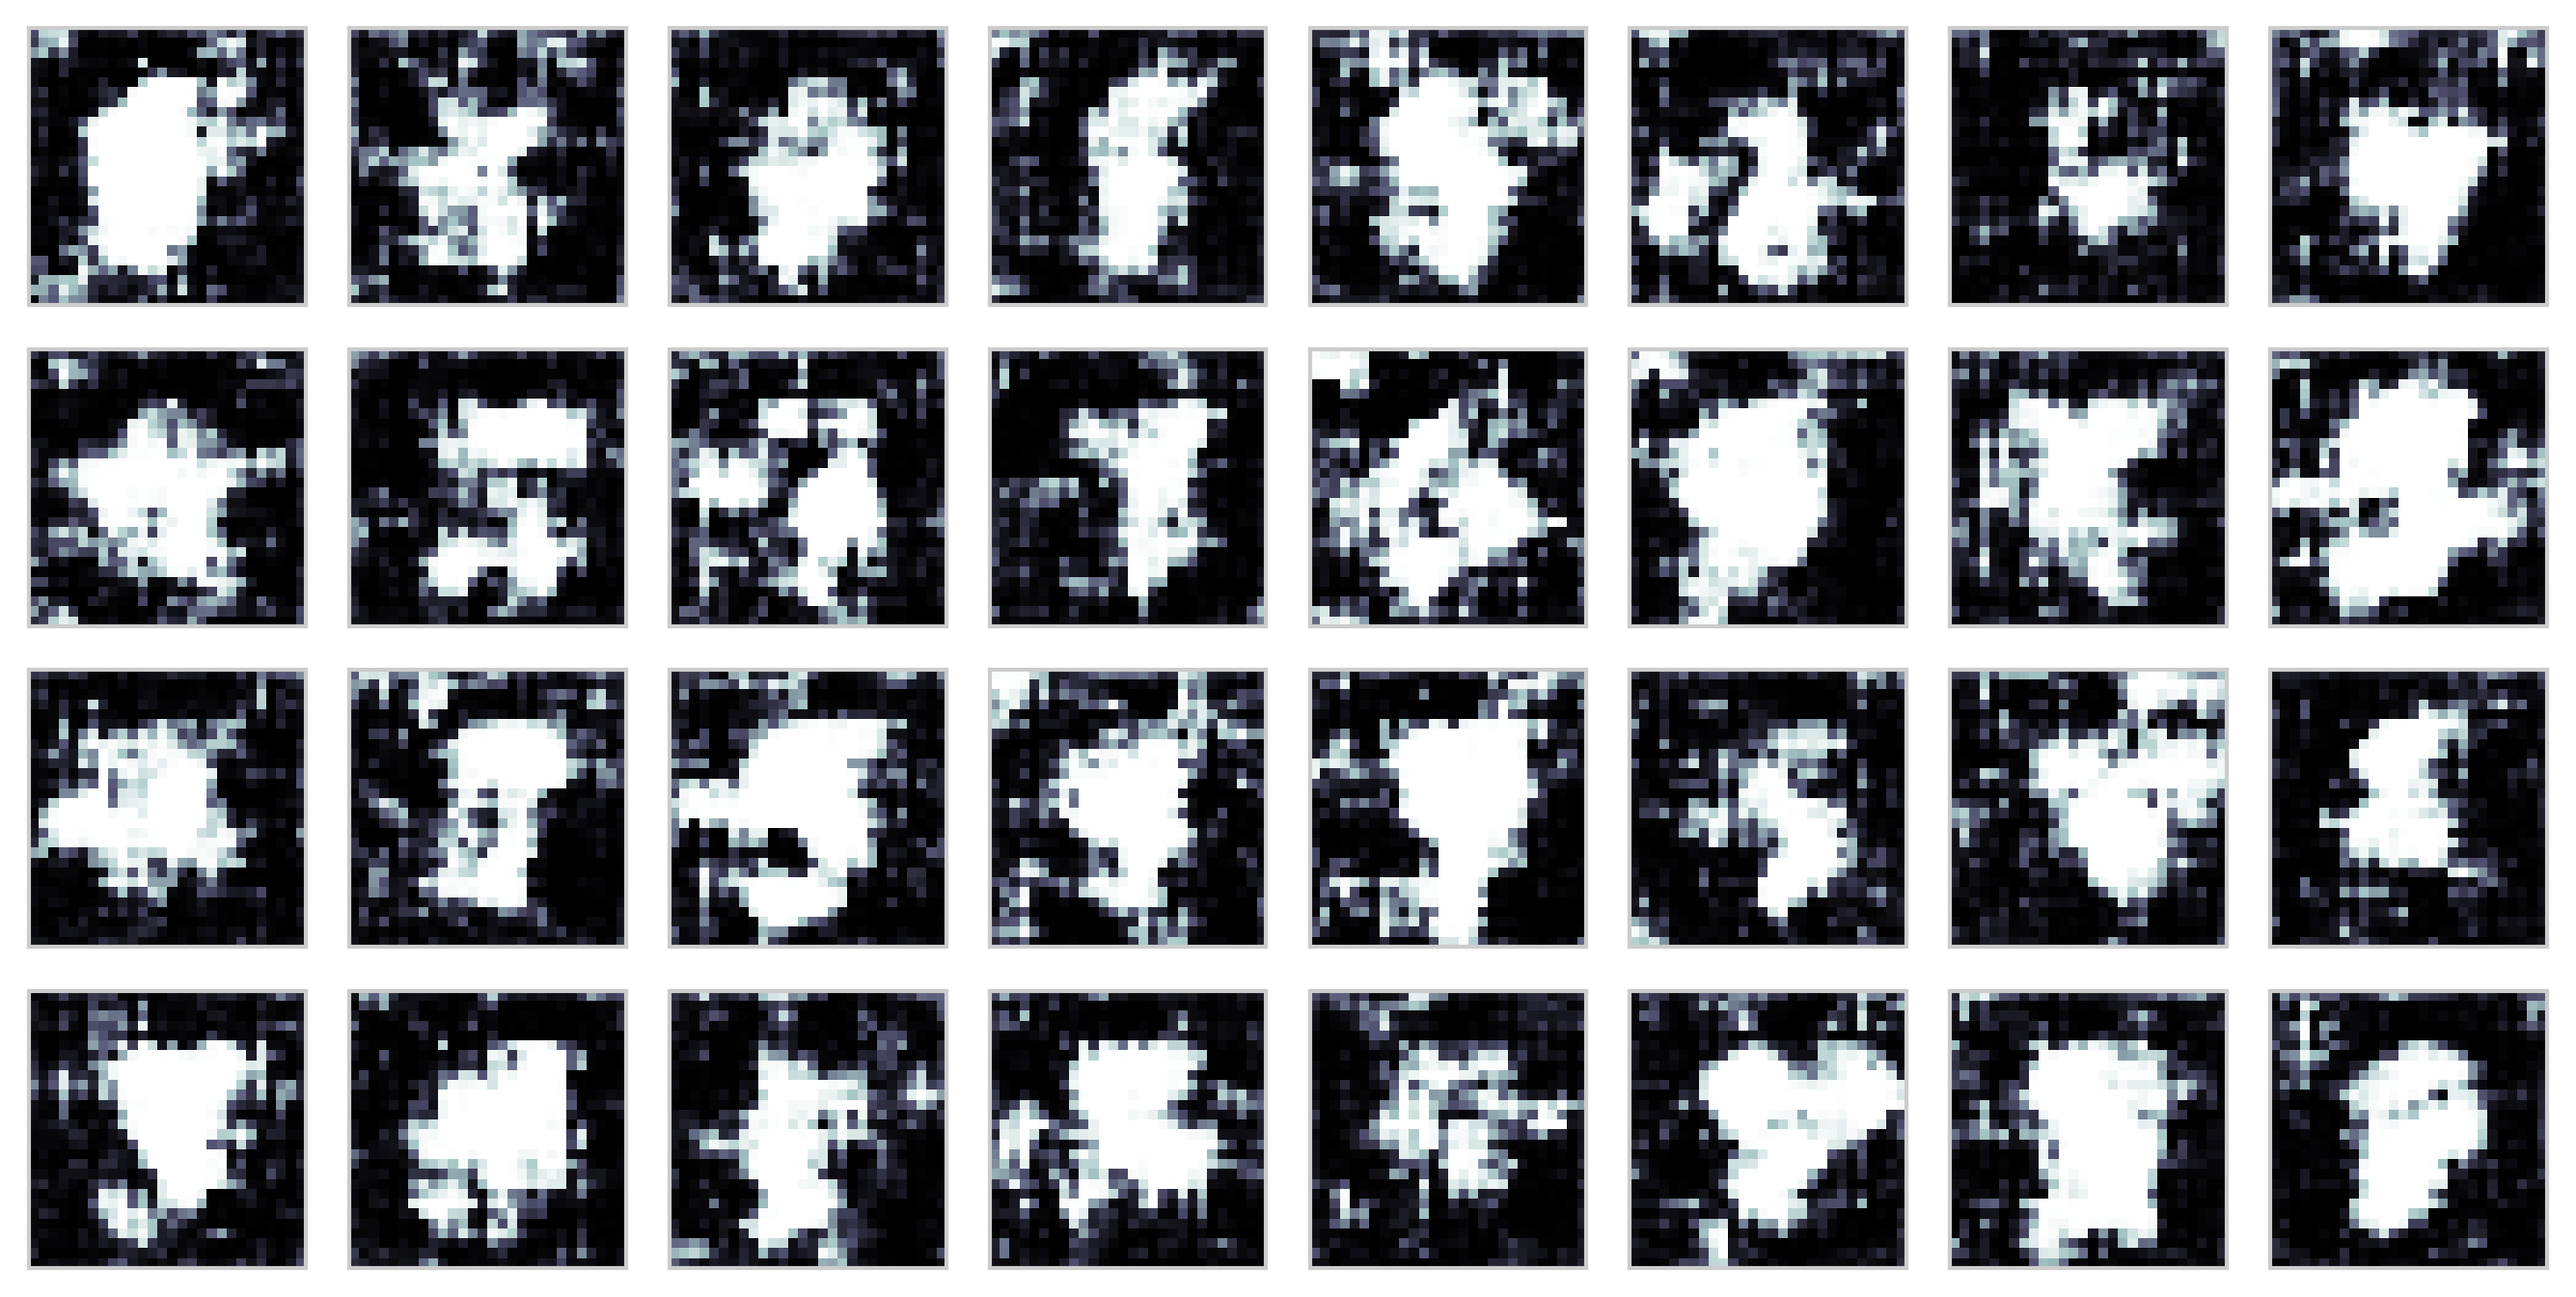

In [23]:
show_images(0.5 * generator.predict(noise_data) + 0.5)

In [24]:
from keras.models import load_model

def save_models(epoch):
    generator.save("dcgan_generator_{}.hdf5".format(epoch))
    discriminator.save("dcgan_discriminator_{}.hdf5".format(epoch))
    combined.save("dcgan_combined_{}.hdf5".format(epoch))

In [25]:
%%time
history1000 = train(1000, 100)

  0 [D loss: 1.168, acc.: 50.00%] [G loss: 0.263, acc.: 100.00%]
100 [D loss: 1.197, acc.: 50.00%] [G loss: 0.250, acc.: 100.00%]
200 [D loss: 1.202, acc.: 50.00%] [G loss: 0.232, acc.: 100.00%]
300 [D loss: 1.120, acc.: 50.00%] [G loss: 0.229, acc.: 97.66%]
400 [D loss: 1.213, acc.: 50.00%] [G loss: 0.221, acc.: 100.00%]
500 [D loss: 1.134, acc.: 50.00%] [G loss: 0.210, acc.: 100.00%]
600 [D loss: 1.162, acc.: 50.00%] [G loss: 0.223, acc.: 100.00%]
700 [D loss: 1.112, acc.: 50.00%] [G loss: 0.219, acc.: 100.00%]
800 [D loss: 1.116, acc.: 50.00%] [G loss: 0.205, acc.: 100.00%]
900 [D loss: 1.119, acc.: 50.00%] [G loss: 0.239, acc.: 100.00%]
CPU times: user 1min 31s, sys: 18.4 s, total: 1min 49s
Wall time: 1min 48s


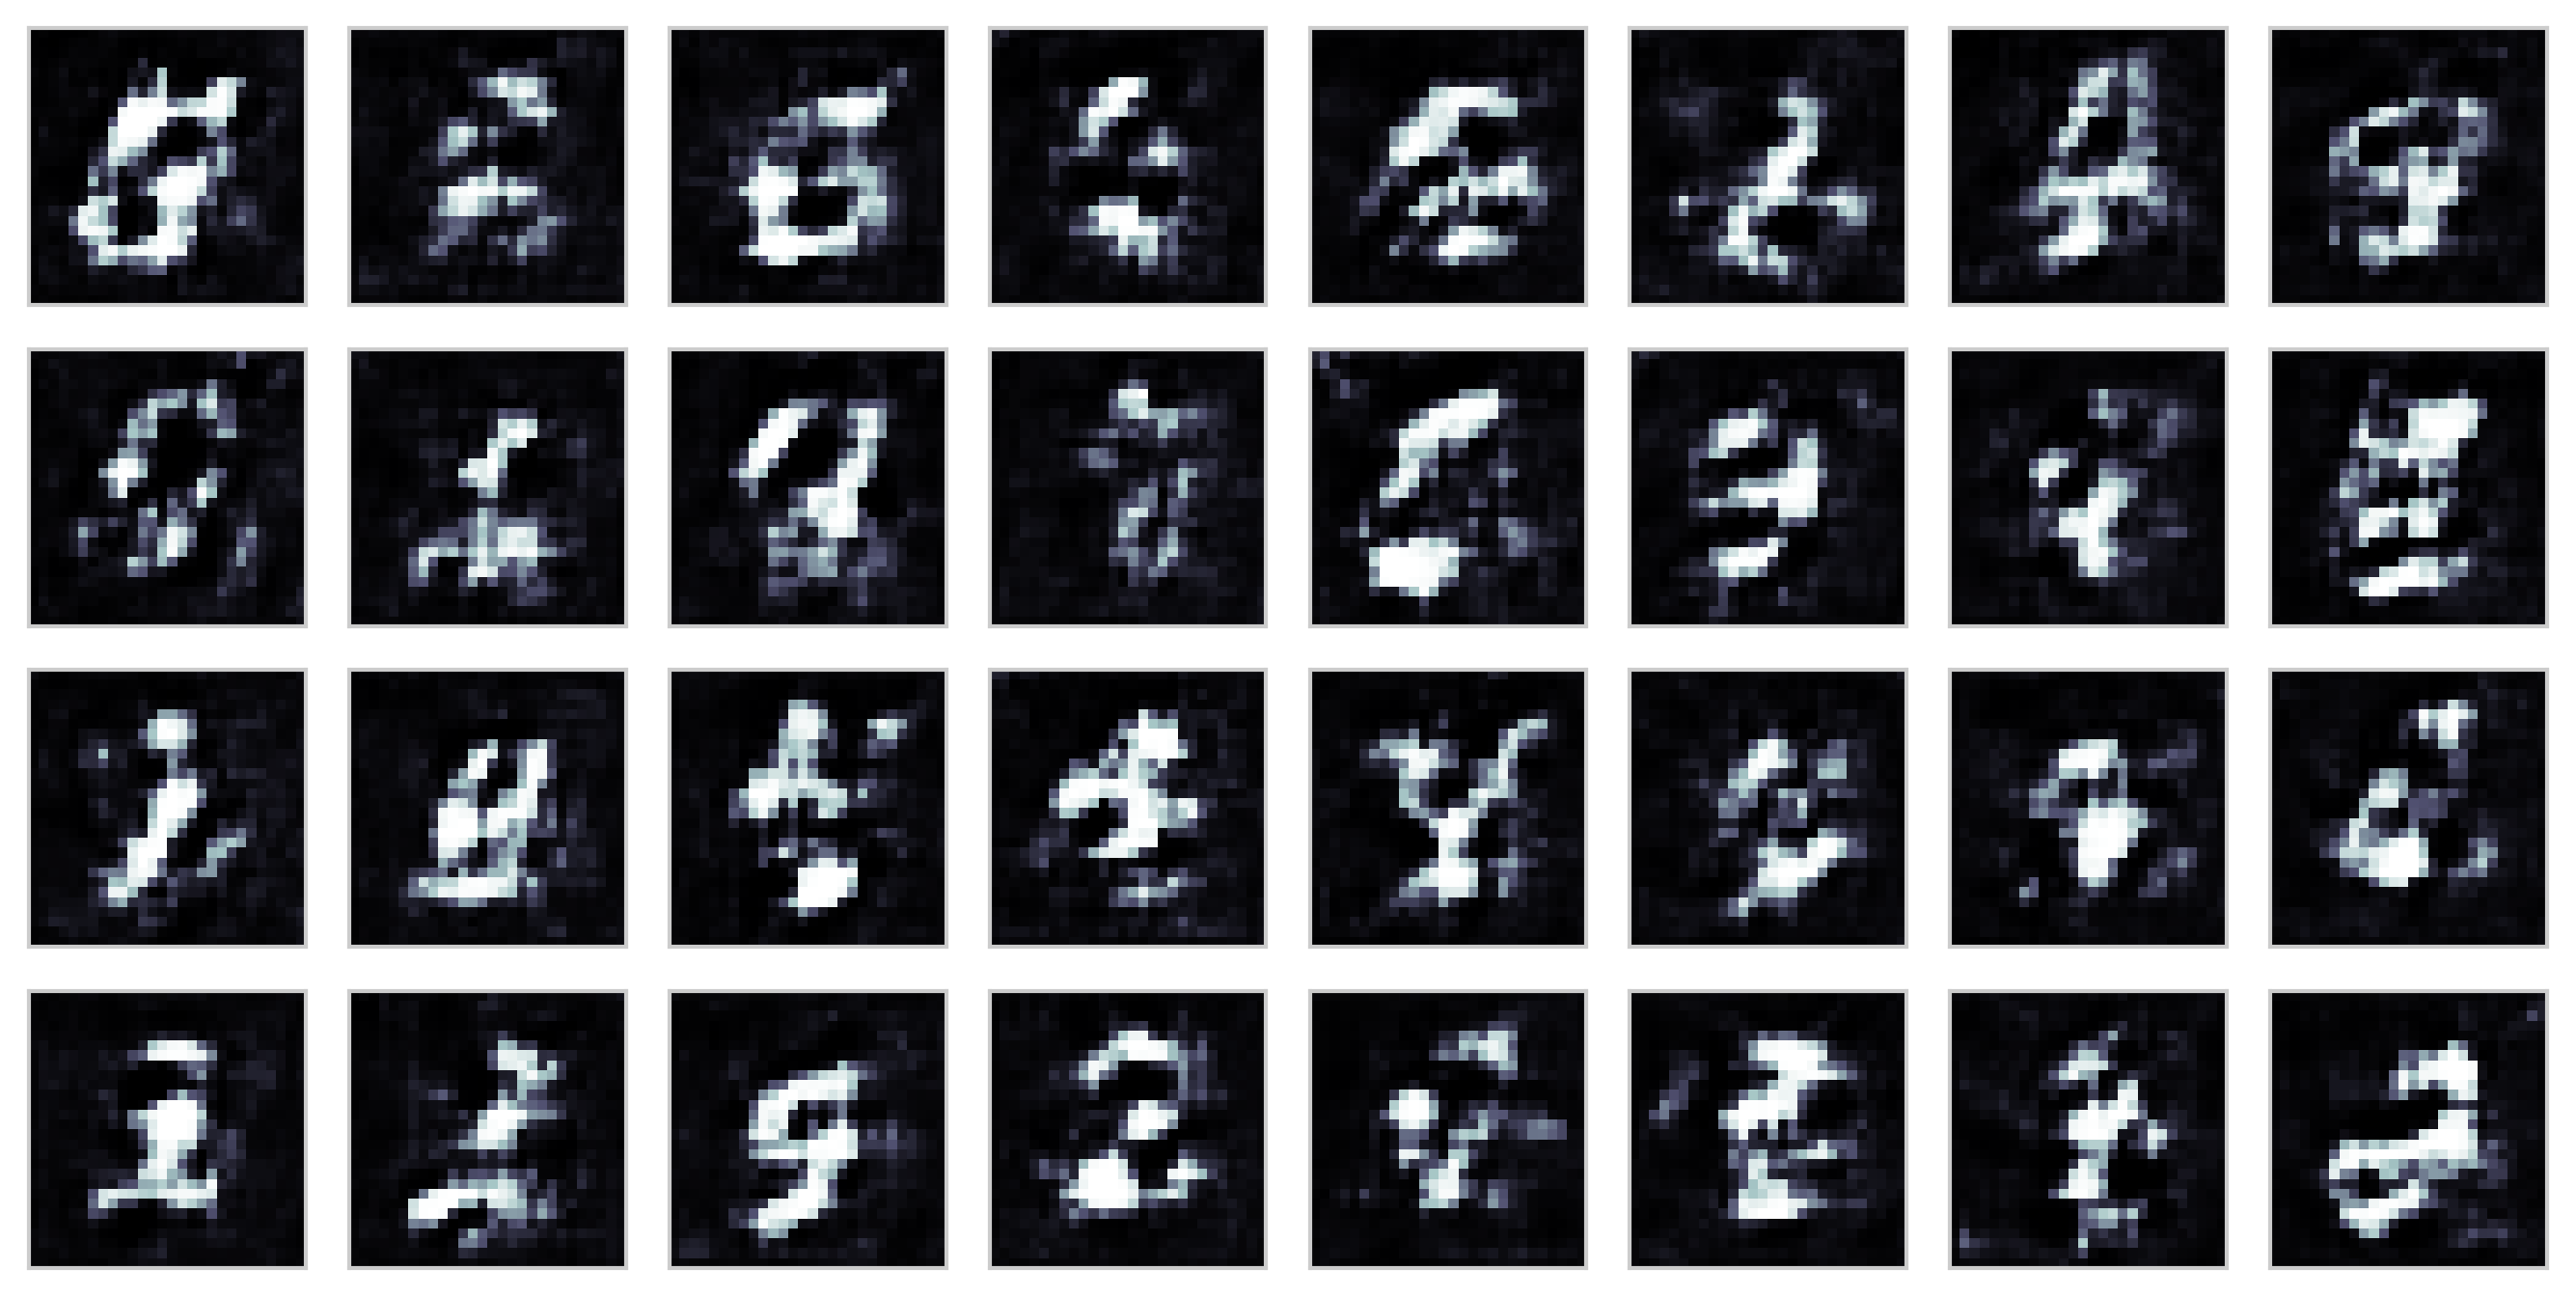

In [26]:
show_images(0.5 * generator.predict(noise_data) + 0.5)

In [27]:
save_models(1000)

In [28]:
%%time
history2000 = train(1000, 100)

  0 [D loss: 1.112, acc.: 50.00%] [G loss: 0.225, acc.: 100.00%]
100 [D loss: 1.046, acc.: 50.00%] [G loss: 0.215, acc.: 100.00%]
200 [D loss: 1.160, acc.: 50.00%] [G loss: 0.227, acc.: 100.00%]
300 [D loss: 1.108, acc.: 50.00%] [G loss: 0.230, acc.: 99.22%]
400 [D loss: 1.194, acc.: 50.00%] [G loss: 0.222, acc.: 99.22%]
500 [D loss: 1.141, acc.: 50.00%] [G loss: 0.246, acc.: 98.44%]
600 [D loss: 1.136, acc.: 50.00%] [G loss: 0.235, acc.: 99.22%]
700 [D loss: 1.145, acc.: 50.00%] [G loss: 0.253, acc.: 99.22%]
800 [D loss: 1.166, acc.: 50.00%] [G loss: 0.247, acc.: 96.88%]
900 [D loss: 1.134, acc.: 50.00%] [G loss: 0.251, acc.: 95.31%]
CPU times: user 1min 30s, sys: 18.6 s, total: 1min 49s
Wall time: 1min 48s


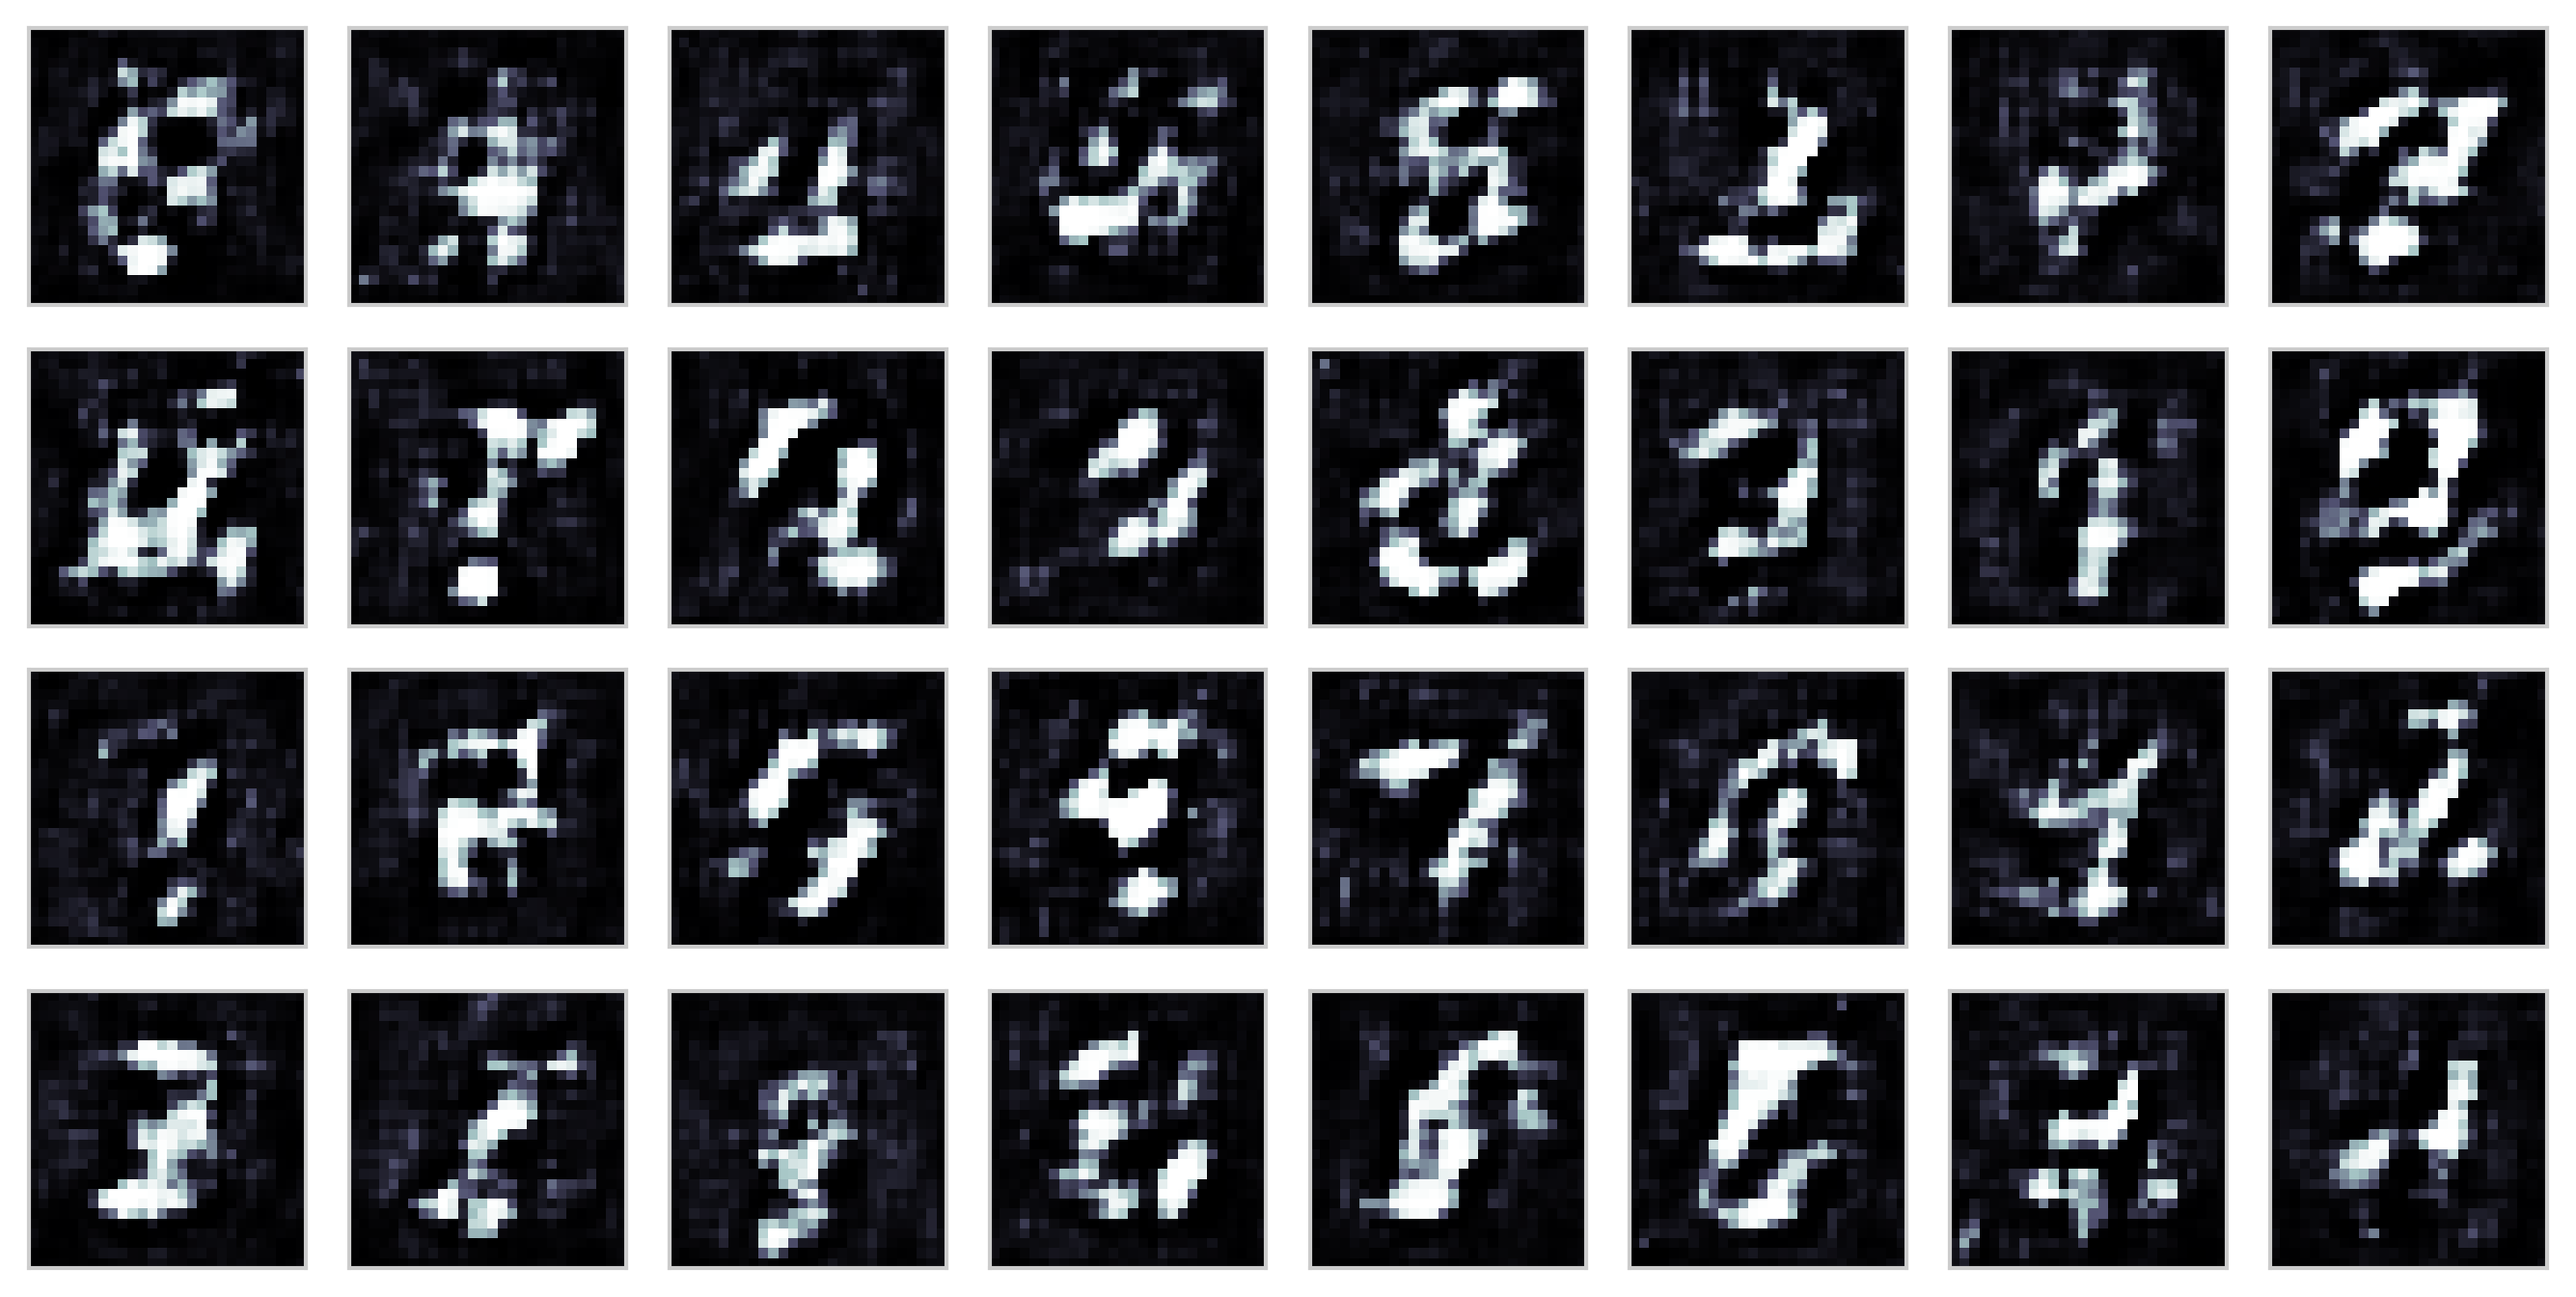

In [29]:
show_images(0.5 * generator.predict(noise_data) + 0.5)

In [30]:
save_models(2000)

In [31]:
%%time
history3000 = train(1000, 100)

  0 [D loss: 1.155, acc.: 50.00%] [G loss: 0.256, acc.: 98.44%]
100 [D loss: 1.136, acc.: 50.78%] [G loss: 0.219, acc.: 97.66%]
200 [D loss: 1.154, acc.: 50.00%] [G loss: 0.257, acc.: 97.66%]
300 [D loss: 1.226, acc.: 50.00%] [G loss: 0.258, acc.: 97.66%]
400 [D loss: 1.181, acc.: 50.00%] [G loss: 0.256, acc.: 98.44%]
500 [D loss: 1.180, acc.: 50.00%] [G loss: 0.255, acc.: 97.66%]
600 [D loss: 1.185, acc.: 50.00%] [G loss: 0.259, acc.: 97.66%]
700 [D loss: 1.136, acc.: 50.00%] [G loss: 0.255, acc.: 96.88%]
800 [D loss: 1.088, acc.: 50.00%] [G loss: 0.272, acc.: 94.53%]
900 [D loss: 1.132, acc.: 51.56%] [G loss: 0.276, acc.: 96.88%]
CPU times: user 1min 30s, sys: 18.8 s, total: 1min 49s
Wall time: 1min 47s


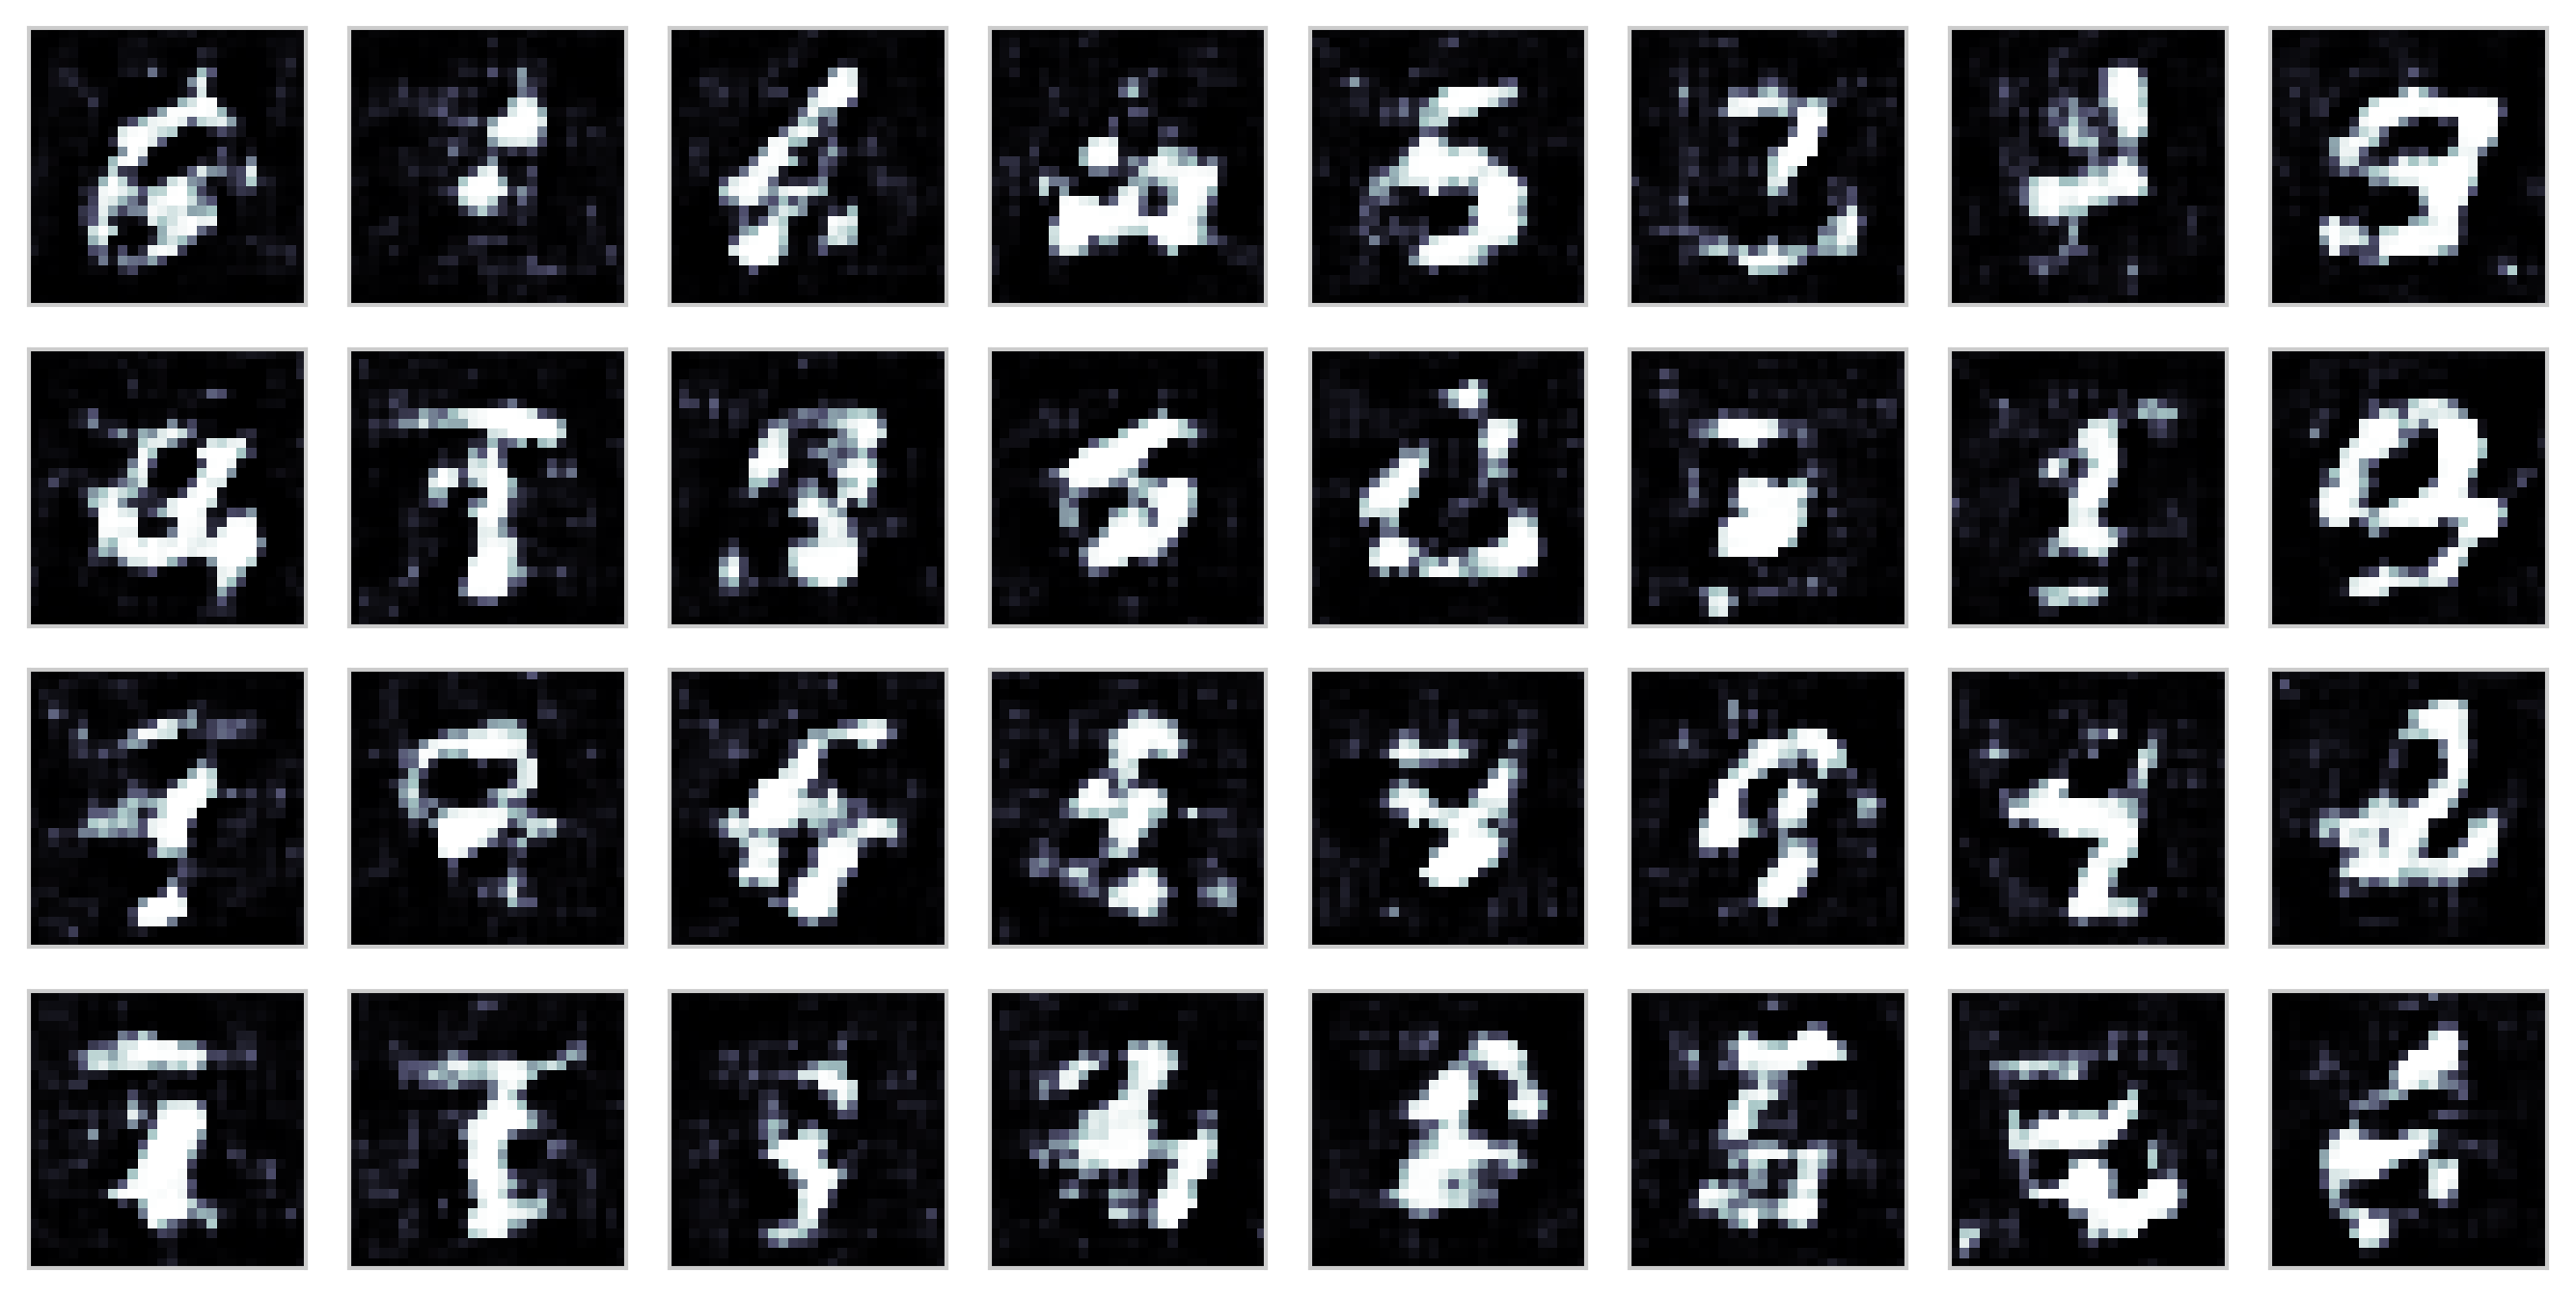

In [32]:
show_images(0.5 * generator.predict(noise_data) + 0.5)

In [33]:
save_models(3000)

In [34]:
%%time
history4000 = train(1000, 100)

  0 [D loss: 1.129, acc.: 49.22%] [G loss: 0.254, acc.: 97.66%]
100 [D loss: 1.156, acc.: 50.78%] [G loss: 0.263, acc.: 97.66%]
200 [D loss: 1.161, acc.: 49.22%] [G loss: 0.294, acc.: 93.75%]
300 [D loss: 1.141, acc.: 50.00%] [G loss: 0.285, acc.: 93.75%]
400 [D loss: 1.005, acc.: 52.34%] [G loss: 0.269, acc.: 96.09%]
500 [D loss: 1.197, acc.: 50.78%] [G loss: 0.305, acc.: 92.97%]
600 [D loss: 1.147, acc.: 50.78%] [G loss: 0.326, acc.: 89.06%]
700 [D loss: 1.111, acc.: 50.78%] [G loss: 0.258, acc.: 96.09%]
800 [D loss: 1.152, acc.: 48.44%] [G loss: 0.329, acc.: 91.41%]
900 [D loss: 1.222, acc.: 50.00%] [G loss: 0.261, acc.: 96.09%]
CPU times: user 1min 30s, sys: 18.7 s, total: 1min 49s
Wall time: 1min 48s


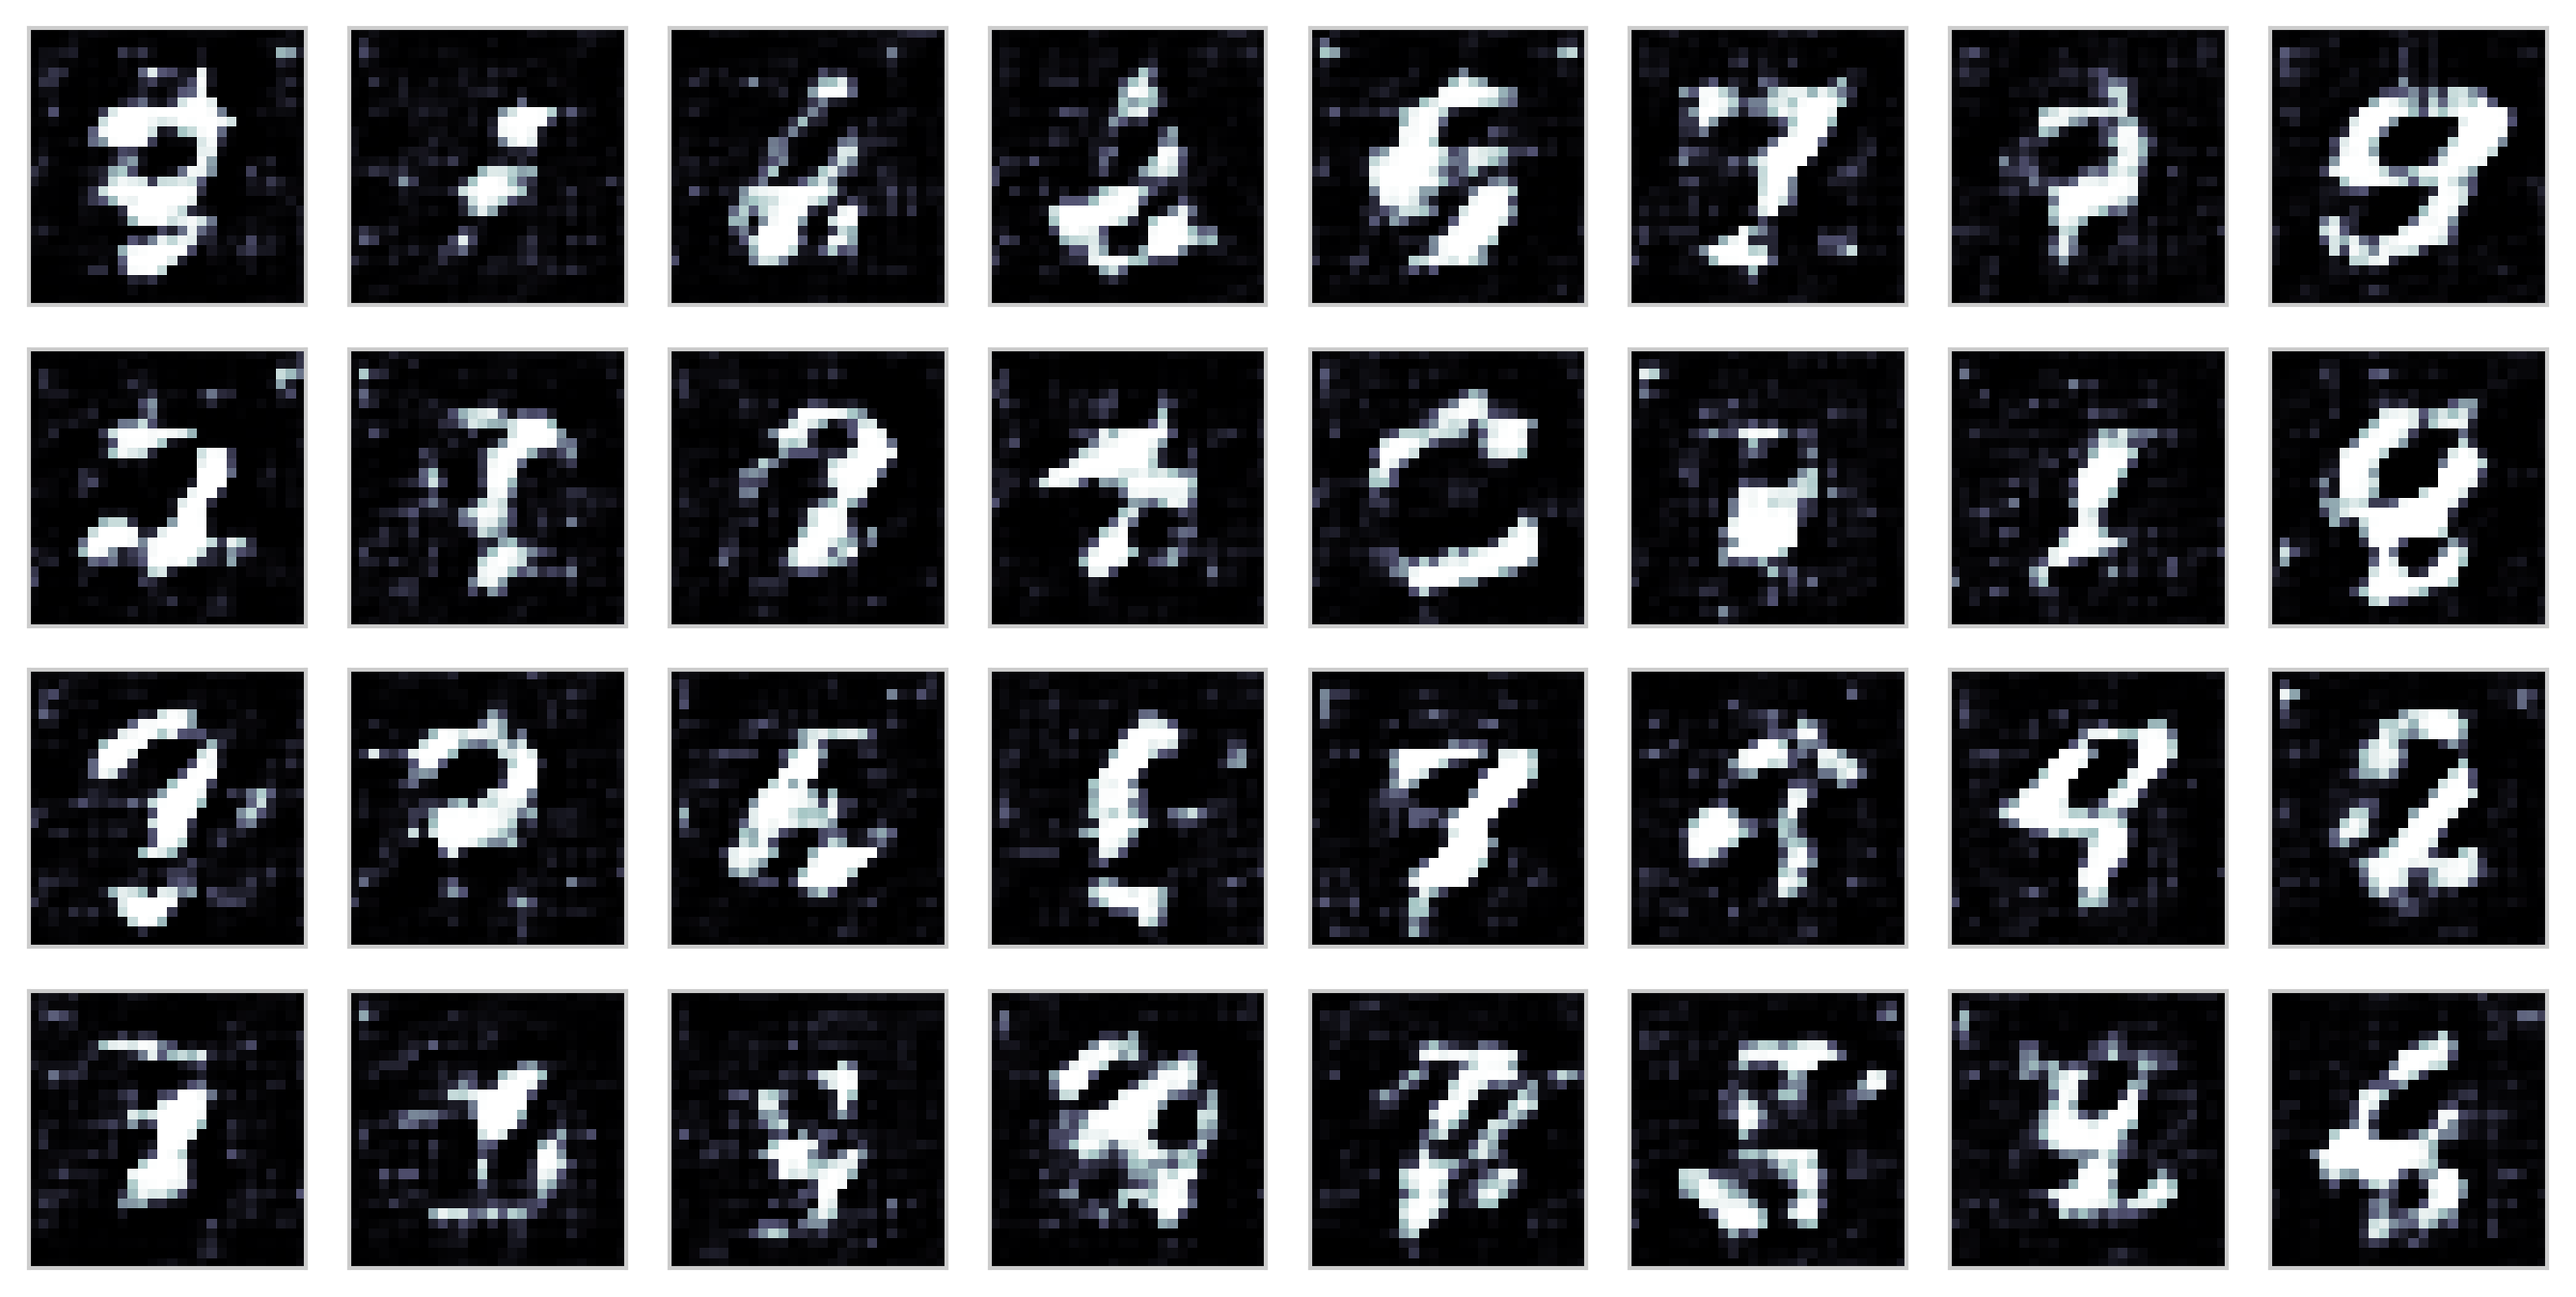

In [35]:
show_images(0.5 * generator.predict(noise_data) + 0.5)

In [36]:
save_models(4000)

In [37]:
%%time
history5000 = train(1000, 100)

  0 [D loss: 1.147, acc.: 50.78%] [G loss: 0.281, acc.: 95.31%]
100 [D loss: 1.156, acc.: 51.56%] [G loss: 0.293, acc.: 95.31%]
200 [D loss: 1.120, acc.: 50.00%] [G loss: 0.281, acc.: 93.75%]
300 [D loss: 1.163, acc.: 48.44%] [G loss: 0.314, acc.: 93.75%]
400 [D loss: 1.185, acc.: 49.22%] [G loss: 0.315, acc.: 89.06%]
500 [D loss: 1.152, acc.: 50.78%] [G loss: 0.303, acc.: 91.41%]
600 [D loss: 1.139, acc.: 50.78%] [G loss: 0.279, acc.: 93.75%]
700 [D loss: 1.156, acc.: 50.00%] [G loss: 0.278, acc.: 95.31%]
800 [D loss: 1.270, acc.: 47.66%] [G loss: 0.270, acc.: 95.31%]
900 [D loss: 1.184, acc.: 51.56%] [G loss: 0.264, acc.: 96.88%]
CPU times: user 1min 30s, sys: 18.5 s, total: 1min 49s
Wall time: 1min 47s


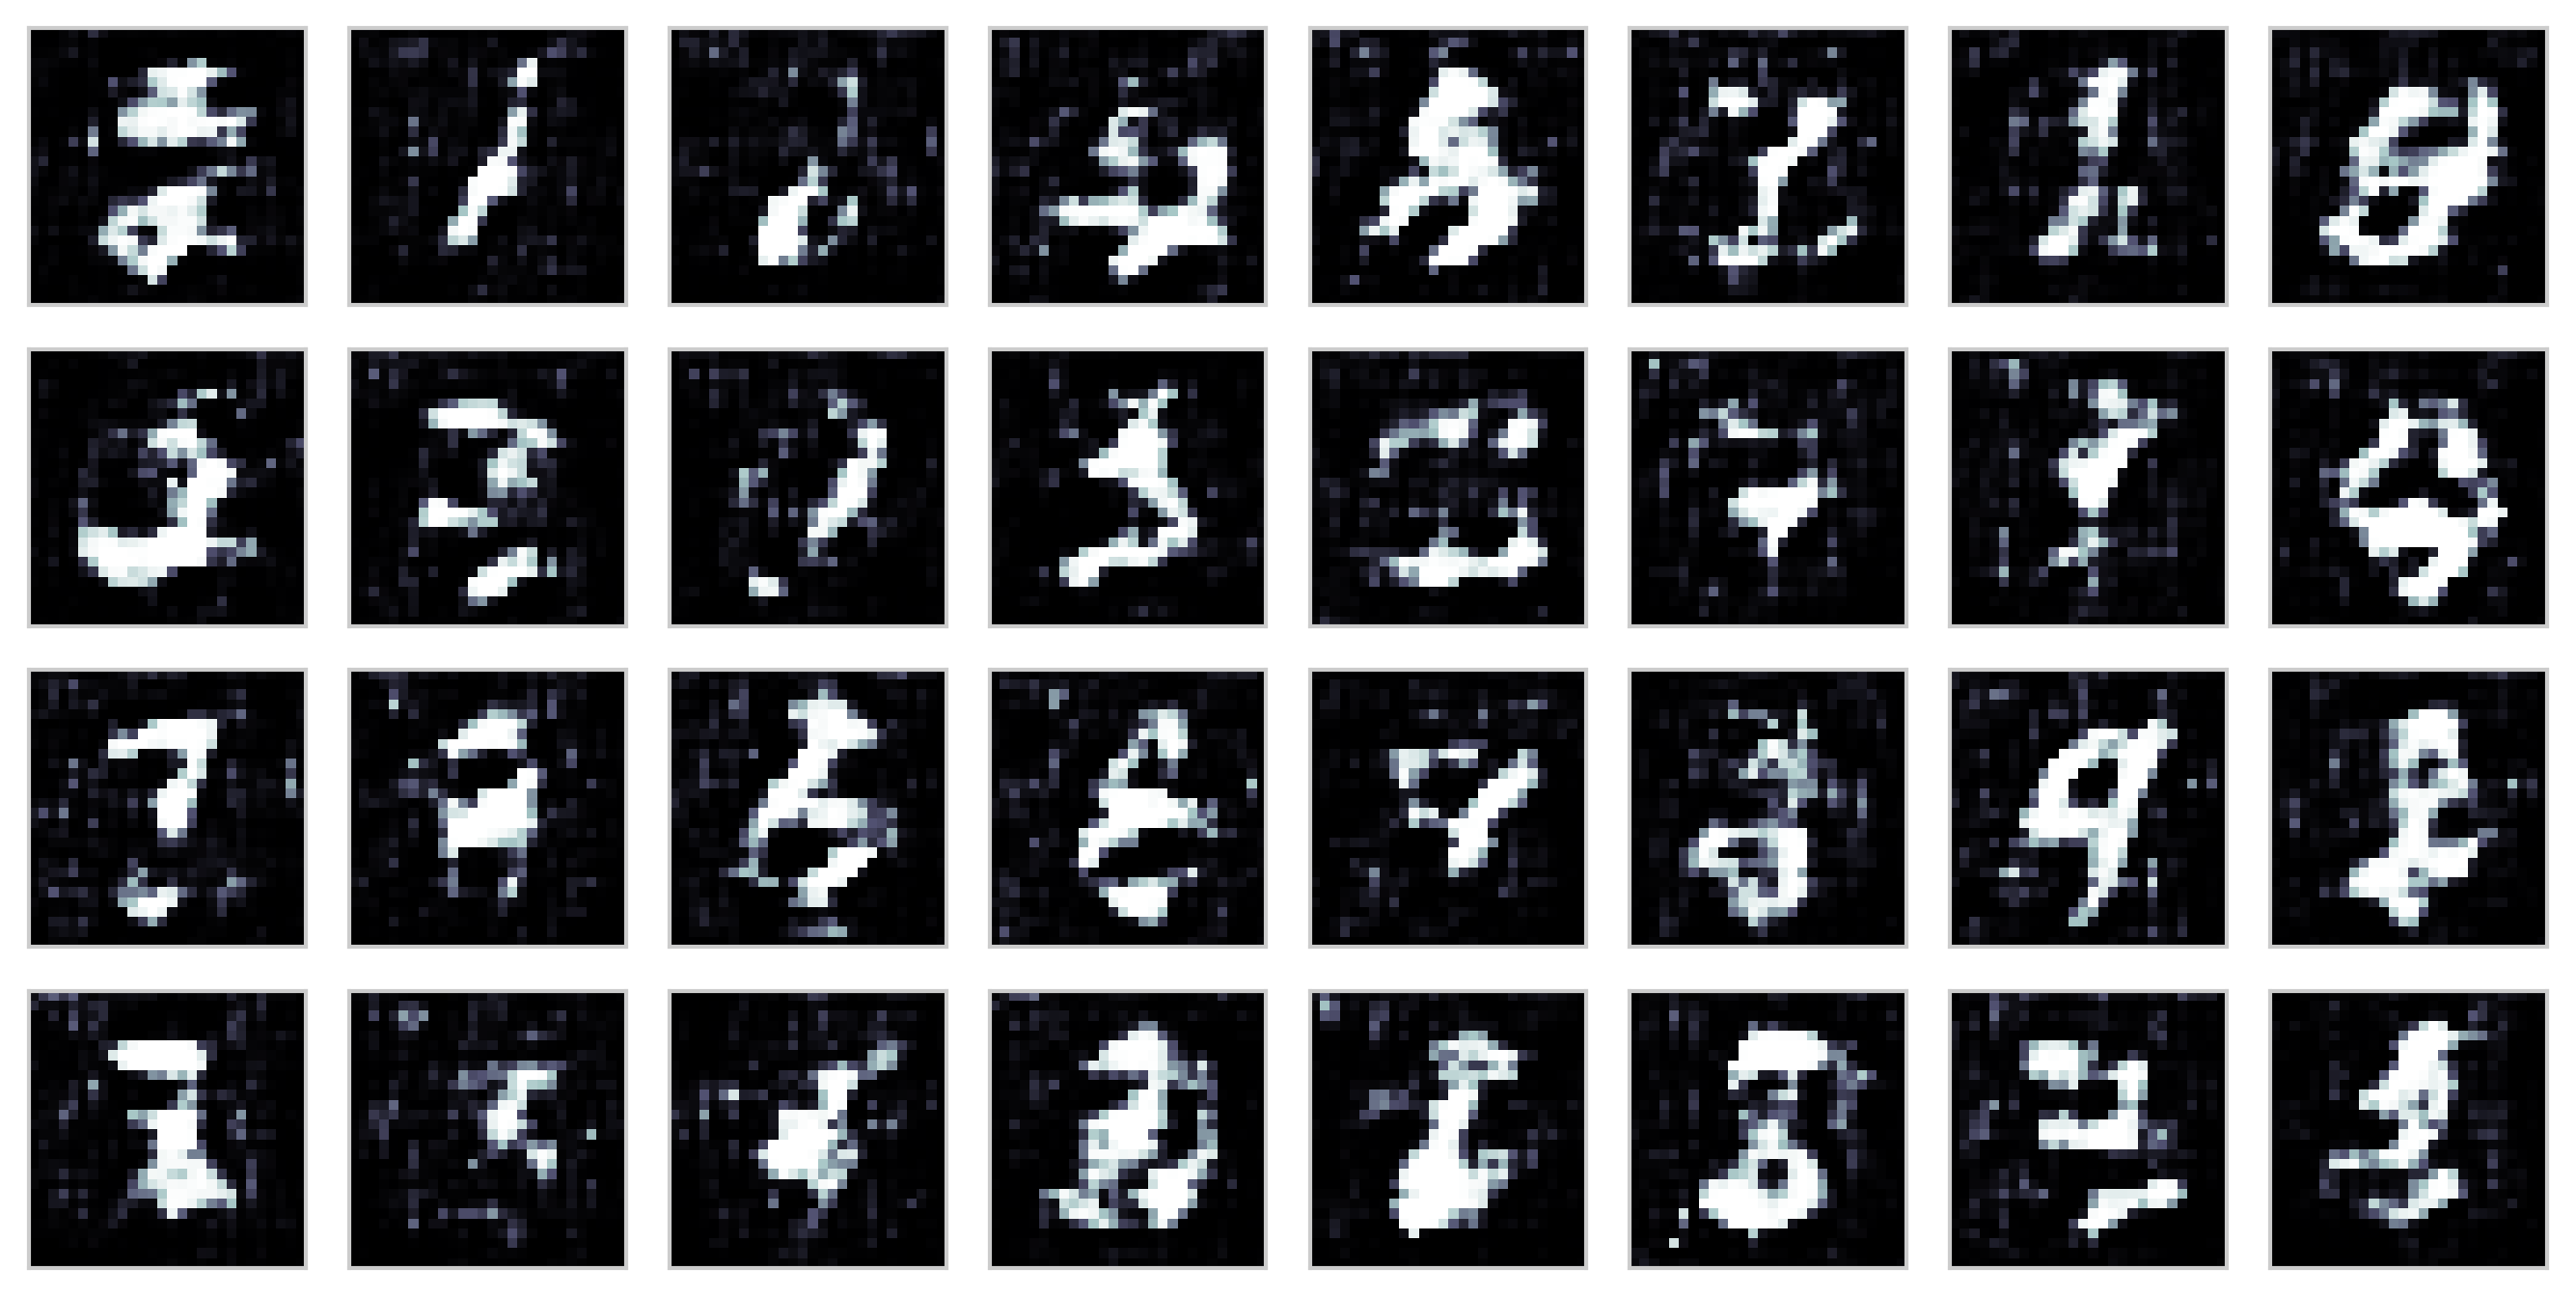

In [38]:
show_images(0.5 * generator.predict(noise_data) + 0.5)

In [39]:
save_models(5000)

In [44]:
%%time
history10000 = train(5000, 100)

    0 [D loss: 1.273, acc.: 50.00%] [G loss: 0.415, acc.: 81.25%]
  100 [D loss: 1.168, acc.: 50.00%] [G loss: 0.320, acc.: 85.94%]
  200 [D loss: 1.246, acc.: 51.56%] [G loss: 0.356, acc.: 85.16%]
  300 [D loss: 1.183, acc.: 49.22%] [G loss: 0.379, acc.: 82.03%]
  400 [D loss: 1.185, acc.: 51.56%] [G loss: 0.406, acc.: 80.47%]
  500 [D loss: 1.124, acc.: 52.34%] [G loss: 0.341, acc.: 92.19%]
  600 [D loss: 1.220, acc.: 50.78%] [G loss: 0.347, acc.: 88.28%]
  700 [D loss: 1.061, acc.: 53.12%] [G loss: 0.382, acc.: 81.25%]
  800 [D loss: 1.211, acc.: 51.56%] [G loss: 0.357, acc.: 86.72%]
  900 [D loss: 1.247, acc.: 49.22%] [G loss: 0.373, acc.: 84.38%]
 1000 [D loss: 1.144, acc.: 50.78%] [G loss: 0.403, acc.: 78.91%]
 1100 [D loss: 1.260, acc.: 49.22%] [G loss: 0.400, acc.: 78.91%]
 1200 [D loss: 1.185, acc.: 52.34%] [G loss: 0.380, acc.: 86.72%]
 1300 [D loss: 1.092, acc.: 52.34%] [G loss: 0.337, acc.: 88.28%]
 1400 [D loss: 1.074, acc.: 50.78%] [G loss: 0.328, acc.: 90.62%]
 1500 [D l

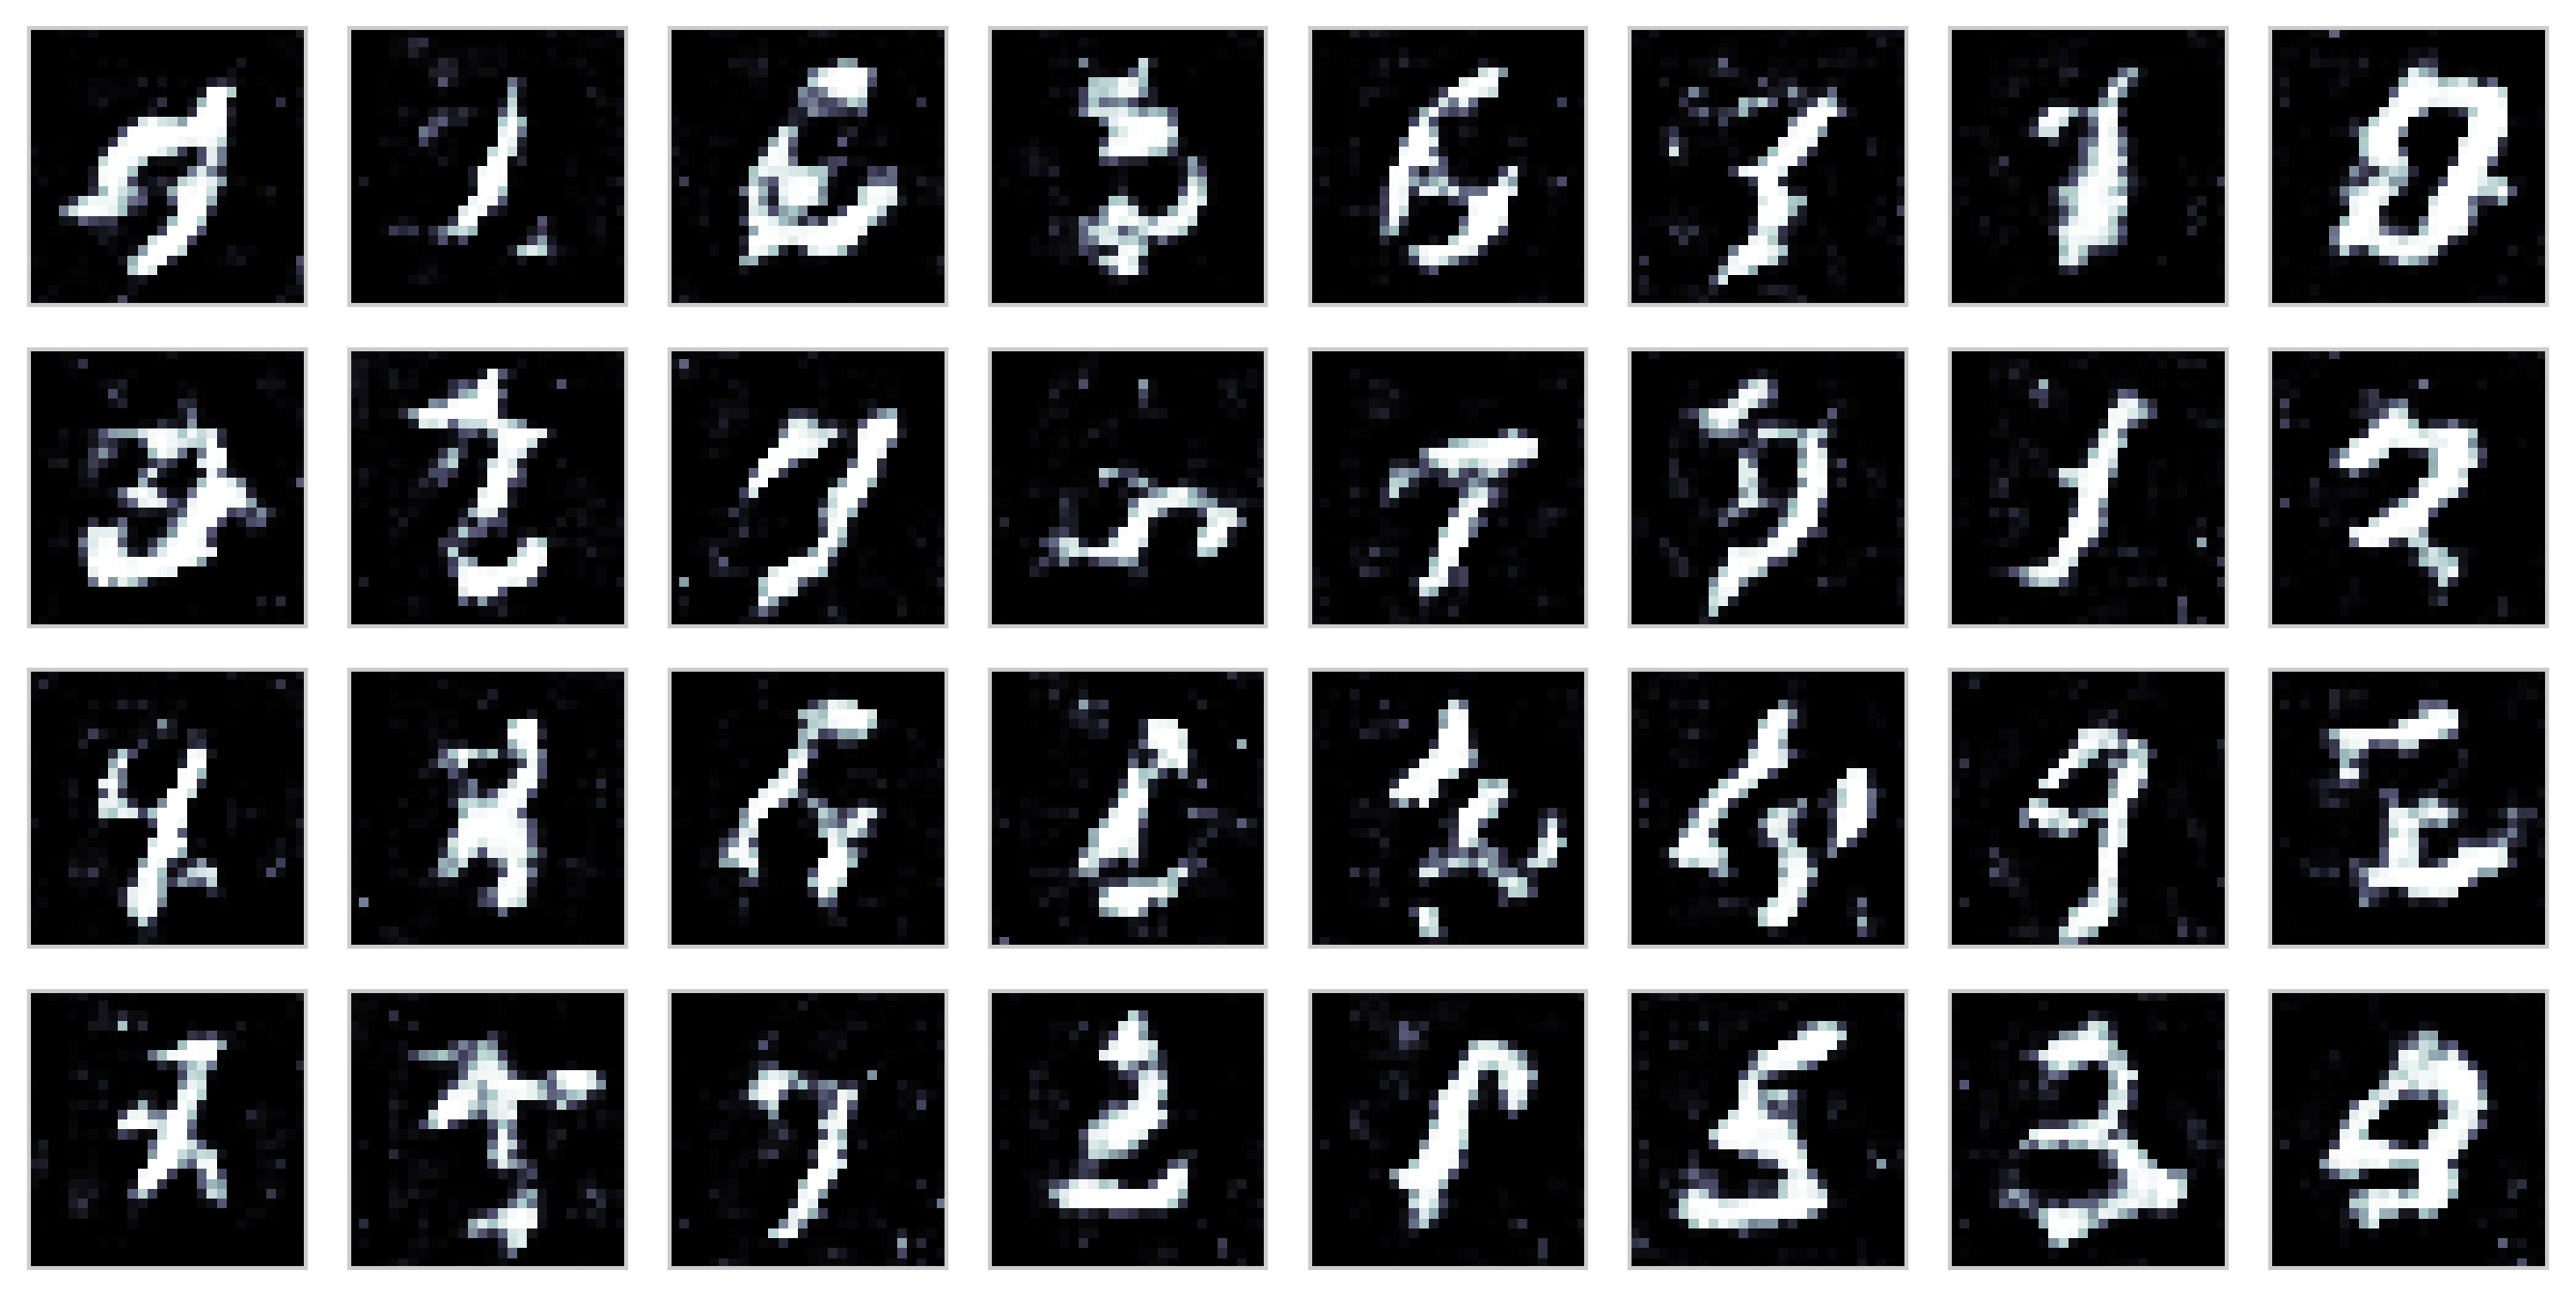

In [45]:
show_images(0.5 * generator.predict(noise_data) + 0.5)

In [46]:
save_models(10000)